# YOLOv8 Pose Estimation Training Notebook
This notebook is designed to train a YOLOv8 Nano Pose model (`yolov8n-pose`) on a custom dataset imported from Roboflow.

**Prerequisites:**
- If using VS Code, select your `.venv` as the Kernel (top right).
- Ensure you have a Python virtual environment (`.venv`) activated. 
    - Ctrl + ` to open terminal inside VSCode. If (.venv) is present, it is activated. 
    - If not: run .venv/Scripts/Activate in the terminal (powershell)

In [ ]:
# Install generic dependencies for YOLOv8 and Roboflow
%pip install ultralytics roboflow ipywidgets

# Install GPU Support (NVIDIA)
Use this cell if you have a dedicated NVIDIA GPU. This installs the CUDA-enabled version of PyTorch. If you do not have a GPU, skip this or standard CPU versions will be used.

In [1]:
# Uninstall existing torch versions to prevent conflicts
%pip uninstall -y torch torchvision torchaudio

# Install PyTorch with CUDA 12.1 support (Adjust cu121 to cu118 if on older drivers)
# Note: Your system must have the NVIDIA Display Driver installed at the OS level.
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp310-cp310-win_amd64.whl (2449.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp310-cp310-win_amd64.whl (4.1 MB)

   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------

In [1]:
import os
import torch
from roboflow import Roboflow
from ultralytics import YOLO

print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU. Warning: Training will be slow.")

# Verify Ultralytics checks (prints environment info)
import ultralytics
ultralytics.checks()

Ultralytics 8.3.235  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Setup complete  (24 CPUs, 31.1 GB RAM, 365.2/1878.4 GB disk)


# Download Dataset from Roboflow

In [ ]:
# Dataset V1 Download
# Initialize Roboflow
rf = Roboflow(api_key="Si22YzQBHnfcu4QV6B91")
project = rf.workspace("dataset-for-deadlift-form-assessment-system-using-computer-vision-and-yolov8pose").project("deadlift-form-assessment-system-4luqm")

# Download dataset (downloads into the current working directory)
# Ensure you select "YOLOv8" format when exporting from Roboflow
dataset = project.version(1).download("yolov8")

# Store the dataset location for training
dataset_yaml_path = os.path.join(dataset.location, "data.yaml")
print(f"Dataset YAML located at: {dataset_yaml_path}")               

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Deadlift-Form-Assessment-System-1 in yolov8:: 100%|██████████| 612/612 [00:00<00:00, 3333.81it/s]

Dataset YAML located at: c:\Users\nghia\Documents\GitHub\gym-pose-estimation-project-2025\Deadlift_Form_Analysis_YoloV8\Deadlift-Form-Assessment-System-1\data.yaml


In [7]:
# Dataset V2 Update Script
                
from roboflow import Roboflow
import shutil
import os

# 1. Clean up the old dataset to avoid confusion (Optional but recommended)
# Replace 'Deadlift-Form-Assessment-System-1' with your actual old folder name
old_dataset_folder = "Deadlift-Form-Assessment-System-1" 
if os.path.exists(old_dataset_folder):
    shutil.rmtree(old_dataset_folder)
    print("Old dataset removed.")

# 2. Download the NEW version (Paste your code from Roboflow below)
rf = Roboflow(api_key="Si22YzQBHnfcu4QV6B91")
project = rf.workspace("dataset-for-deadlift-form-assessment-system-using-computer-vision-and-yolov8pose").project("deadlift-form-assessment-system-4luqm")
dataset = project.version(2).download("yolov8") # Ensure this says version(2) or higher

# 3. Update your dataset path variable
dataset_yaml_path = os.path.join(dataset.location, "data.yaml")
print(f"New dataset ready at: {dataset_yaml_path}")


Old dataset removed.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Deadlift-Form-Assessment-System-2 in yolov8:: 100%|██████████| 1756/1756 [00:00<00:00, 3043.62it/s]

New dataset ready at: c:\Users\nghia\Documents\GitHub\gym-pose-estimation-project-2025\Deadlift_Form_Analysis_YoloV8\Deadlift-Form-Assessment-System-2\data.yaml


In [9]:
import os
import yaml

# 1. Define the dataset root directory
# 'dataset.location' comes from the Roboflow download cell. 
# If that variable is lost, hardcode the path from your error message:
# dataset_root = r"C:\Users\nghia\Documents\GitHub\gym-pose-estimation-project-2025\Deadlift_Form_Analysis_YoloV8\Deadlift-Form-Assessment-System-1"
dataset_root = dataset.location 

print(f"Scanning dataset at: {dataset_root}")

# 2. Helper function to find a valid images folder
def find_image_folder(root, candidates):
    for folder in candidates:
        path = os.path.join(root, folder, "images")
        if os.path.exists(path):
            return path
    return None

# 3. Load the existing yaml to keep class names and keypoint shapes
yaml_path = os.path.join(dataset_root, "data.yaml")
with open(yaml_path, 'r') as f:
    config = yaml.safe_load(f)

# 4. Find actual paths
train_path = find_image_folder(dataset_root, ["train"])
val_path = find_image_folder(dataset_root, ["valid", "val"])
test_path = find_image_folder(dataset_root, ["test"])

# 5. Update the config
if train_path:
    config['train'] = train_path
    print(f"✅ Found Train: {train_path}")
else:
    raise FileNotFoundError("Could not find a 'train/images' folder. Check your dataset download.")

if val_path:
    config['val'] = val_path
    print(f"✅ Found Val: {val_path}")
else:
    # CRITICAL FIX: If no validation folder exists, use train folder for validation
    print("⚠️ 'valid' folder missing. Using 'train' folder for validation to prevent error.")
    config['val'] = train_path

if test_path:
    config['test'] = test_path
    print(f"✅ Found Test: {test_path}")
else:
    # Remove test key if it doesn't exist to prevent errors
    config.pop('test', None)

# 6. Save with Absolute Paths
with open(yaml_path, 'w') as f:
    yaml.dump(config, f)

print(f"\nFixed data.yaml saved to: {yaml_path}")


Scanning dataset at: c:\Users\nghia\Documents\GitHub\gym-pose-estimation-project-2025\Deadlift_Form_Analysis_YoloV8\Deadlift-Form-Assessment-System-2
✅ Found Train: c:\Users\nghia\Documents\GitHub\gym-pose-estimation-project-2025\Deadlift_Form_Analysis_YoloV8\Deadlift-Form-Assessment-System-2\train\images
⚠️ 'valid' folder missing. Using 'train' folder for validation to prevent error.

Fixed data.yaml saved to: c:\Users\nghia\Documents\GitHub\gym-pose-estimation-project-2025\Deadlift_Form_Analysis_YoloV8\Deadlift-Form-Assessment-System-2\data.yaml


# Train the Model

In [ ]:
# Train YOLOv8 Pose Model on Custom Dataset V1
# Load a pretrained YOLOv8n-pose model
model = YOLO('yolov8n-pose.pt')

# Train the model
# imgsz=640 is standard. Adjust epochs based on dataset size (usually 50-100).
results = model.train(
    data=dataset_yaml_path,  # Path to the dataset downloaded above
    epochs=50,               # Number of training passes
    imgsz=640,               # Image size
    batch=16,                # Batch size (reduce to 8 if you hit 'Out of Memory' errors)
    device=0 if torch.cuda.is_available() else 'cpu', # Force GPU usage if available
    project='runs/pose',     # Project folder for saving results
    name='custom_training'   # Name of this specific training run
)


Ultralytics 8.3.235  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\nghia\Documents\GitHub\gym-pose-estimation-project-2025\Deadlift_Form_Analysis_YoloV8\Deadlift-Form-Assessment-System-1\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cu

In [10]:
# Load your previous BEST model instead of 'yolov8n-pose.pt' for dataset V2 fine-tuning
model = YOLO(r'runs/pose/custom_training2/weights/best.pt') 

model.train(
    data=dataset_yaml_path,
    epochs=50, # You can use fewer epochs (e.g., 30-50) for fine-tuning
    imgsz=640,
    project='runs/pose',
    name='custom_training_v2' # New name for the new run
)


Ultralytics 8.3.235  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\nghia\Documents\GitHub\gym-pose-estimation-project-2025\Deadlift_Form_Analysis_YoloV8\Deadlift-Form-Assessment-System-2\data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/pose/custom_training2/weights/best.pt, momentum=0.937, mosaic=1

ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001B2FD46B4C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.0340

# Compare yolov8n-pose.pt and best.pt

## Image inference comparison

Testing on image: dlvid1_mp4-0000_jpg.rf.27d593ef4077c352fbb867da45432b9d.jpg

image 1/1 c:\Users\nghia\Documents\GitHub\gym-pose-estimation-project-2025\Deadlift_Form_Analysis_YoloV8\Deadlift-Form-Assessment-System-2\train\images\dlvid1_mp4-0000_jpg.rf.27d593ef4077c352fbb867da45432b9d.jpg: 640x640 1 person, 27.3ms
Speed: 3.5ms preprocess, 27.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\nghia\Documents\GitHub\gym-pose-estimation-project-2025\Deadlift_Form_Analysis_YoloV8\Deadlift-Form-Assessment-System-2\train\images\dlvid1_mp4-0000_jpg.rf.27d593ef4077c352fbb867da45432b9d.jpg: 640x640 1 person, 25.4ms
Speed: 3.1ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


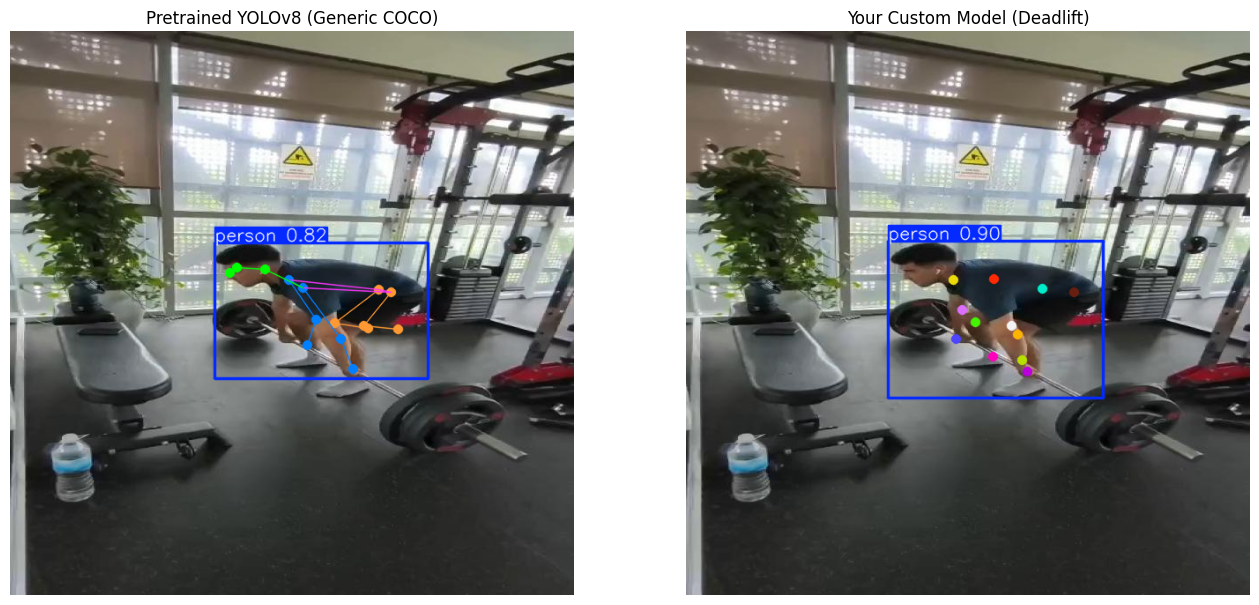

In [12]:
%matplotlib inline
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os

# 1. Load the models
# 'yolov8n-pose.pt' is the generic pretrained model (trained on COCO, 17 keypoints)
base_model = YOLO('yolov8n-pose.pt')

# 'best.pt' is your custom trained model (12 keypoints)
# Update this path if your run folder name is different (e.g., custom_training3)
custom_model_path = r'runs/pose/custom_training_v22/weights/best.pt' 
custom_model = YOLO(custom_model_path)

# 2. Select a test image from your validation set
# We'll pick the first image found in the validation folder
val_images_path = r'Deadlift-Form-Assessment-System-2/train/images'
test_image_name = os.listdir(val_images_path)[0]
test_image_path = os.path.join(val_images_path, test_image_name)

print(f"Testing on image: {test_image_name}")

# 3. Run Inference
# We use a low confidence threshold (conf=0.3) to ensure we see what the model 'thinks'
res_base = base_model.predict(test_image_path, conf=0.3)[0]
res_custom = custom_model.predict(test_image_path, conf=0.3)[0]

# 4. Plot Results Side-by-Side
# Ultralytics results have a .plot() method that returns a BGR numpy array
img_base = res_base.plot()    # Plot generic predictions
img_custom = res_custom.plot() # Plot your custom predictions

# Convert BGR to RGB for Matplotlib
img_base_rgb = cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB)
img_custom_rgb = cv2.cvtColor(img_custom, cv2.COLOR_BGR2RGB)

# Display using Matplotlib
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title("Pretrained YOLOv8 (Generic COCO)")
plt.imshow(img_base_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Your Custom Model (Deadlift)")
plt.imshow(img_custom_rgb)
plt.axis('off')

plt.show()

## Video inference comparision

In [14]:
import cv2
import numpy as np
from ultralytics import YOLO

# Use a safer codec (avc1) and .mp4 extension
video_path = "Test Video\\nghia.MOV"
output_path = "comparison_output3_finetuned.mp4"

try:
    # Load Models
    model_base = YOLO('yolov8n-pose.pt')
    model_custom = YOLO(r'runs/pose/custom_training_v22/weights/best.pt')

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise Exception("Error: Could not open video file.")

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Try 'avc1' first (H.264). If this fails, change to 'mp4v'
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width * 2, height))

    print(f"Processing video: {video_path}...")

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Inference
        res_base = model_base(frame, verbose=False, conf=0.5)[0]
        res_custom = model_custom(frame, verbose=False, conf=0.5)[0]

        # Plot & Stack
        combined_frame = np.hstack((res_base.plot(), res_custom.plot()))

        # Write
        out.write(combined_frame)

    print("Video processing complete.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # THIS BLOCK RUNS NO MATTER WHAT
    if 'cap' in locals() and cap.isOpened():
        cap.release()
    if 'out' in locals():
        out.release()
    print("Resources released. File should now be playable.")


Processing video: Test Video\nghia.MOV...
Video processing complete.
Resources released. File should now be playable.
